In [24]:
### 앙상블 학습에 들어가기전에 왜 앙상블 학습이 더 좋은가를 위한 구현
# 이항정리를 통해 모델들의 에러율이 같다고 했을때 앙상블 학습을 이용하면
# 더 에러율이 낮아진다는걸 증명

from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * (error ** k) * (1-error) ** (n_classifier - k) for k in range(k_start, n_classifier + 1)]
    
    return sum(probs)

print(ensemble_error(n_classifier=11, error=0.25))


### 기존 모델들이 각각 0.25의 에러율을 가지고 있을때, 11개의 모델을 이어붙인 앙상블 학습을 하게되면
### 에러율이 0.034까지 떨어지는걸 볼 수 있음.

0.03432750701904297


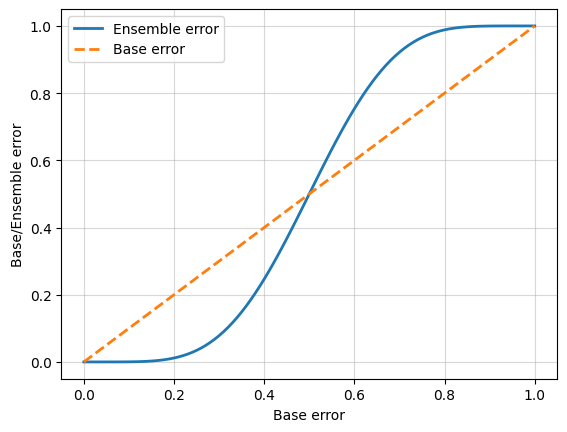

In [25]:
### 각 모델의 에러율이 0~1사이일때 11개의 모델로 앙상블 학습을 한다 했을때 에러율 그려보기

import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

### 그래프를 보면 기존 모델들의 에러율이 0.5 이상이라면 오히려 앙상블 학습을 하는게 더 나쁜 결과를 가져오는걸 볼 수 있음.

In [26]:
### 앙상블 학습기를 밑바닥부터 구현

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
import numpy as np
import operator

def name_estimators(estimators):
    return [
        (est.__class__.__name__.lower(), est)
        for est in estimators
    ]

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"
     
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key : value for key, value in name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
            
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_].T)
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights, )), axis=1, arr=predictions)
        
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights) ### 여기서 np.mean과의 차이는 np.mean은 항상 산술평균이고,
                                                                     ### np.average는 인자를 어떻게 넣느냐에 따라서 산술평균 or 가중평균이 될 수 있음.
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out
    
    def _get_tags(self):
        return {"estimator_type": "classifier"}
            

In [27]:
### 위에서 구현한 classifier 한번 사용을 위한 빌드업

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()

X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# 데이터 가져오기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)


In [28]:
### 10겹 교차검증으로 성능보기

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

# 앙상블을 위한 classifier 3개 만들기
clf1 = LogisticRegression(solver='liblinear', penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# 파이프라인으로 결합

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

print('10겹 교차검증')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC = %0.2f [%s]" %(scores.mean(), label))

10겹 교차검증
ROC AUC = 0.92 [Logistic Regression]
ROC AUC = 0.87 [Decision Tree]
ROC AUC = 0.85 [KNN]


In [ ]:
# 버전 미스로 인한 오류 ㅠㅠ
my_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, my_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC = %0.2f [%s]" %(scores.mean(), label))

AttributeError: 'list' object has no attribute 'T'

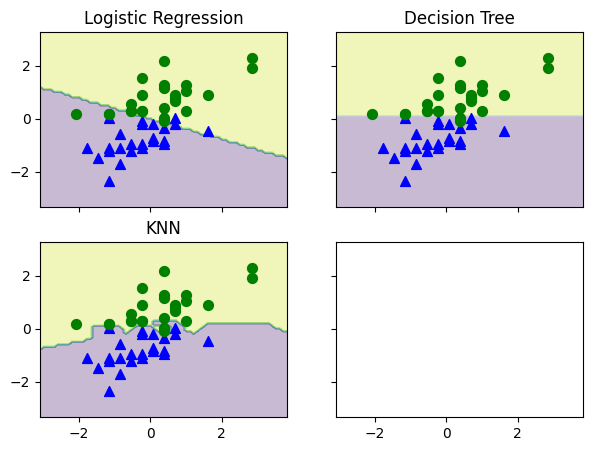

In [31]:
from itertools import product

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

all_clf = [pipe1, clf2, pipe3, my_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show()

In [32]:
### 앙상블 기법중 배깅을 구현해보자

import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# 책에선 편의를 위해 클래스 1은 제외
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [33]:
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [54]:
### 사이킷런의 배깅 분류기 사용

from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)
# 배깅 기법은 편향은 줄여주진 못하고 분산을 줄이는 역할을 하기 때문에
# 랜덤트리를 만들때 일부로 큰 편향과 큰 분산을 가진 트리로 만든다. (따로 가지치기를 하지 않아서 깊이가 깊은 트리)

bag = BaggingClassifier(estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0,
                        bootstrap=True, bootstrap_features=False, random_state=1)

# 성능 비교해보기

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))


### 결과를 보면 결정트리는 확실히 분산이 높아서 과적합에 걸린걸 볼 수 있고,
### 배깅 분류기를 사용하면 분산이 줄어들어 과적합이 줄어든걸 볼 수 있다.

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


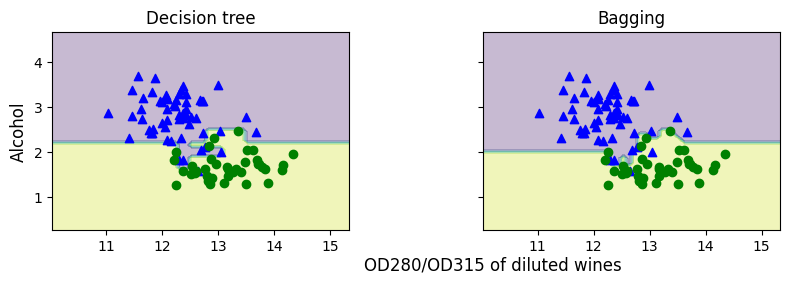

In [ ]:
### 결정트리와 배깅 분류기의 결정경계

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

### 현실에서는 더 복잡한 차원의 데이터셋을 사용함. 그러면 당연히 모델이 훨씬 복잡해질테고, 결정트리가 과대적합 될 가능성이 매우커짐
### 그런 기준에서 보면 배깅 기법을 사용해서 분산을 줄여주는것이 합당함.


In [60]:
### AdaBoosting

from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)
ada = AdaBoostClassifier(estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)

# 결정트리
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

# Adaboost
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))


# 결과를 보면 확실히 결정트리는 깊이가 1밖에 안되니 과소적합에 걸린걸 알 수 있음 (전체적으로 정확도가 다 낮음)
# 반면에 에이다부스트는 결정트리보단 확실히 정확도면에서 더 높은걸 볼 수 있음.

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875
에이다부스트의 훈련 정확도/테스트 정확도 0.968/0.917


In [ ]:
### 결정 경계 그려보기

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()